# Kaggle - Football Prediction

## Introduction

This notebook was created to participate in the `Football Match Probability Prediction` competition on `kaggle.com` (https://www.kaggle.com/competitions/football-match-probability-prediction/data). The competition's goal is to **use machine learning models** to predict the probabilities of the outcome of football matches.

## Start of the project

### Import modules

In [1]:
import pandas as pd
import numpy as np

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.model_selection import KFold, StratifiedKFold, cross_val_score, GridSearchCV

In [4]:
from imblearn.over_sampling import RandomOverSampler

In [5]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

In [81]:
import tensorflow
from keras.utils.np_utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.metrics import CategoricalAccuracy

### Import data

To avoid warnings, the data types for the descriptive features (see below) are defined before importing the data:

* target - draw, home or away depending on what team won the game.
* home_team_name - name of the Home team.
* away_team_name - name of the Away team.
* match_date - match date (UTC).
* league_name - league name.
* league_id - league id; note that league names can be identical for two differents id.
* is_cup - if 1 the match is played for a cup competition.
* home_team_coach_id - id of the Home team coach.
* away_team_coach_id - id of the Away team coach.

In [124]:
dtypes = {"target": "object", "home_team_name": "object", "away_team_name": "object", "league_name": "object",
          "is_cup": "int64", "home_team_coach_id": "float64", "away_team_coach_id": "float64"}

In [125]:
train_data = pd.read_csv("train.csv", dtype = dtypes, index_col = [0], parse_dates = ["match_date"])

In [126]:
train_data.rename_axis(None, inplace = True)

In [127]:
del dtypes["target"]

In [128]:
test_data = pd.read_csv("test.csv", dtype = dtypes, index_col = [0], parse_dates = ["match_date"])

In [129]:
test_data.rename_axis(None, inplace = True)

### Exploratory Data Analysis

#### Target classes

In [130]:
train_data["target"].value_counts(normalize = True, sort = True) * 100

home    43.369269
away    31.705998
draw    24.924733
Name: target, dtype: float64

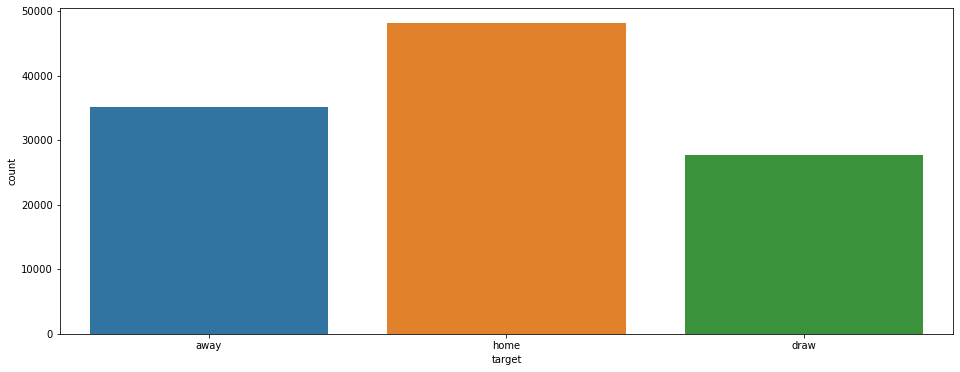

In [131]:
fig, ax = plt.subplots(figsize = (16, 6))
sns.countplot(data = train_data, x = "target", ax = ax)
plt.show()

Three classes: home team win, away team win and draw. There might be a problem of label imbalance. Keep that in mind. Moreover, it might be necessary to encode the strings as integer values for some models.

In [132]:
train_data["target"] = train_data["target"].map({"draw": 0, "home": 1, "away": 2})

#### Features

Stated on the Kaggle competition webpage: 'The features provided are divided into two parts: the descriptive features and the historical features. Descriptive features are point-in-time descriptions of the match that has to be predicted. Historical features contain past information of the 10 games previously played by the Home and the Away team.'

Hence, we differentiate between descriptive as well as historical features during the EDA.

In [133]:
desc_features = list(train_data.columns[1:9])

In [134]:
hist_features = list(train_data.columns[9:])

#### Descriptive features

In [135]:
train_data[desc_features].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 110938 entries, 11906497 to 17786297
Data columns (total 8 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   home_team_name      110937 non-null  object        
 1   away_team_name      110937 non-null  object        
 2   match_date          110938 non-null  datetime64[ns]
 3   league_name         110937 non-null  object        
 4   league_id           110938 non-null  int64         
 5   is_cup              110938 non-null  float64       
 6   home_team_coach_id  89217 non-null   float64       
 7   away_team_coach_id  89123 non-null   float64       
dtypes: datetime64[ns](1), float64(3), int64(1), object(3)
memory usage: 11.6+ MB


As indicated by the table, there are missing values:

In [136]:
for col in desc_features:
    print(f'{col}: {train_data[col].isnull().sum()} missing values')

home_team_name: 1 missing values
away_team_name: 1 missing values
match_date: 0 missing values
league_name: 1 missing values
league_id: 0 missing values
is_cup: 0 missing values
home_team_coach_id: 21721 missing values
away_team_coach_id: 21815 missing values


Missing value in features 'home_team_name', 'away_team_name' and 'league_name' all belong to same index. Hence, the row will be removed from dataset.

In [137]:
# train_data[train_data["home_team_name"].isnull()].index[0]

In [138]:
# train_data[train_data["away_team_name"].isna()].index[0]

In [139]:
# train_data[train_data["league_name"].isna()].index[0]

In [140]:
train_data.drop(index = train_data[train_data["home_team_name"].isnull()].index[0], axis = 0, inplace = True)

Missing values in the remaining two features 'home_team_coach_id' & 'away_team_coach_id' are not relevant, as they will be removed in the next step. Assumption: id-features do not contain useful information when trying to predict the outcome of football matches. Moreover, names of teams are assumed to have no impact. Drop the features as well.

In [141]:
for column in ["league_id", "home_team_coach_id", "away_team_coach_id"]:
    print(f'Correlation between target and {column}: {round(train_data[["target", column]].corr().iloc[0, 1], 2)}')

Correlation between target and league_id: 0.01
Correlation between target and home_team_coach_id: 0.02
Correlation between target and away_team_coach_id: -0.01


In [142]:
train_data.drop(columns = ["home_team_name", "away_team_name", "league_name", "league_id",
                           "home_team_coach_id", "away_team_coach_id"], axis = 1, inplace = True)

In [143]:
test_data.drop(columns = ["home_team_name", "away_team_name", "league_name", "league_id",
                          "home_team_coach_id", "away_team_coach_id"], axis = 1, inplace = True)

#### Historical features

In [144]:
train_data[hist_features].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 110937 entries, 11906497 to 17786297
Columns: 180 entries, home_team_history_match_date_1 to away_team_history_league_id_10
dtypes: float64(160), object(20)
memory usage: 153.2+ MB


Are there missing values for the historical features as well?

In [145]:
#for col in hist_features:
#    print(f'{col}: {train_data[col].isnull().sum()} missing values')

There some to be a lot of missing values (see also cells below). As I do not know how appropriately replace the missing values, they will be dropped during data preprocessing. Definitely space for improvements. 

In [146]:
print('Test data containts {:,.0f} missing values.'.format(sum(train_data.isna().sum())))

Test data containts 1,673,716 missing values.


In [147]:
print(f'That are {round(sum(train_data.isna().sum()) / len(train_data), 1)}% percent of the test dataset.')

That are 15.1% percent of the test dataset.


Due to vast amount of features the examination is divided into several units. First ten features are related to historical matches. Each entry is a date. Hence, the data type is changed.

In [148]:
# train_data[hist_features[0:10]].info()

In [149]:
train_data[hist_features[0:10]] = train_data[hist_features[0:10]].astype("datetime64")

In [150]:
test_data[hist_features[0:10]] = test_data[hist_features[0:10]].astype("datetime64")

Second subset contains features indicating whether the home team played the historical match at home.

In [151]:
# train_data[hist_features[10:20]].info()

Third subset: is the historical match a cup match?

In [152]:
# train_data[hist_features[20:30]].info()

Fourth subset: number of goals the home team scored in the historical match.

In [153]:
# train_data[hist_features[30:40]].info()

Fifth subset: number of goals the home team's opponent scored in the historical match.

In [154]:
# train_data[hist_features[40:50]].info()

Sixth subset: home team's rating for the historical match.

In [155]:
# train_data[hist_features[50:60]].info()

Seventh subset: home team's opponent's rating for the historical match.

In [156]:
# train_data[hist_features[60:70]].info()

Eight subset: ID of the home team coach. Will be dropped due to reasons already discussed.

In [157]:
# train_data[hist_features[70:80]].info()

In [158]:
for column_index in range(70, 80):
    column = train_data.columns[column_index]
    print(f'Correlation between target and {column}: {round(train_data[["target", column]].corr().iloc[0, 1], 2)}')

Correlation between target and home_team_history_opponent_rating_8: 0.08
Correlation between target and home_team_history_opponent_rating_9: 0.08
Correlation between target and home_team_history_opponent_rating_10: 0.07
Correlation between target and home_team_history_coach_1: 0.02
Correlation between target and home_team_history_coach_2: 0.02
Correlation between target and home_team_history_coach_3: 0.02
Correlation between target and home_team_history_coach_4: 0.02
Correlation between target and home_team_history_coach_5: 0.02
Correlation between target and home_team_history_coach_6: 0.02
Correlation between target and home_team_history_coach_7: 0.02


Ninth subset: home team's league ID. Will be dropped due to reasons already discussed.

In [159]:
# train_data[hist_features[80:90]].info()

In [160]:
for column_index in range(80, 90):
    column = train_data.columns[column_index]
    print(f'Correlation between target and {column}: {round(train_data[["target", column]].corr().iloc[0, 1], 2)}')

Correlation between target and home_team_history_coach_8: 0.02
Correlation between target and home_team_history_coach_9: 0.02
Correlation between target and home_team_history_coach_10: 0.01
Correlation between target and home_team_history_league_id_1: 0.01
Correlation between target and home_team_history_league_id_2: 0.01
Correlation between target and home_team_history_league_id_3: 0.01
Correlation between target and home_team_history_league_id_4: 0.01
Correlation between target and home_team_history_league_id_5: 0.01
Correlation between target and home_team_history_league_id_6: 0.01
Correlation between target and home_team_history_league_id_7: 0.0


As indicated above, the irrelevant columns are dropped:

In [161]:
train_data.drop(columns = hist_features[70:80], axis = 1, inplace = True)
test_data.drop(columns = hist_features[70:80], axis = 1, inplace = True)
train_data.drop(columns = hist_features[80:90], axis = 1, inplace = True)
test_data.drop(columns = hist_features[80:90], axis = 1, inplace = True)

Remaining subsets are related to the away team and contain similar information presented above for the home team.

In [162]:
# train_data[hist_features[90:100]].info()

In [163]:
train_data[hist_features[90:100]] = train_data[hist_features[90:100]].astype("datetime64")

In [164]:
test_data[hist_features[90:100]] = test_data[hist_features[90:100]].astype("datetime64")

In [165]:
# train_data[hist_features[100:110]].info()

In [166]:
# train_data[hist_features[110:120]].info()

In [167]:
# train_data[hist_features[120:130]].info()

In [168]:
# train_data[hist_features[130:140]].info()

In [169]:
# train_data[hist_features[130:140]].info()

In [170]:
# train_data[hist_features[140:150]].info()

In [171]:
# train_data[hist_features[150:160]].info()

In [172]:
# train_data[hist_features[160:170]].info()

In [173]:
# train_data[hist_features[170:180]].info()

In [174]:
train_data.drop(columns = hist_features[160:170], axis = 1, inplace = True)
test_data.drop(columns = hist_features[160:170], axis = 1, inplace = True)
train_data.drop(columns = hist_features[170:180], axis = 1, inplace = True)
test_data.drop(columns = hist_features[170:180], axis = 1, inplace = True)

Next, we create new features based on all date-based features. The newly created features indicate the difference (counted in days) between the match date and the respective historical match:

In [175]:
for i in range(1, 11):
    home_column = f'home_team_history_match_date_{i}'
    away_column = f'away_team_history_match_date_{i}'
    
    train_data[f'home_team_history_match_days_ago_{i}'] = (train_data['match_date'] - train_data[home_column]).dt.days
    train_data[f'away_team_history_match_days_ago_{i}'] = (train_data['match_date']- train_data[away_column]).dt.days

Same procedure for the test data:

In [176]:
for i in range(1, 11):
    home_column = f'home_team_history_match_date_{i}'
    away_column = f'away_team_history_match_date_{i}'
    
    test_data[f'home_team_history_match_days_ago_{i}'] = (test_data['match_date'] - test_data[home_column]).dt.days
    test_data[f'away_team_history_match_days_ago_{i}'] = (test_data['match_date'] - test_data[away_column]).dt.days

Finally, all date-based features are dropped:

In [177]:
train_data_date_based_columns = train_data.select_dtypes(include = "datetime64").columns
test_data_date_based_columns = test_data.select_dtypes(include = "datetime64").columns

In [178]:
train_data.drop(columns = train_data_date_based_columns, axis = 1, inplace = True)

In [179]:
test_data.drop(columns = test_data_date_based_columns, axis = 1, inplace = True)

### Preprocessing the data

#### Handling remaining missing values

As no appropriate method to deal with the missing values in the historical values was provided yet, they will be dropped to enable modelling.

In [180]:
train_data = train_data.dropna()

#### Resampling to remove imbalance in targets

First, separate features from targets/labels:

In [181]:
features = train_data.drop(columns = ["target"], axis = 1)

In [182]:
labels = train_data.loc[:, "target"]

As stated at the beginning the labels are imbalanced. To avoid biased results, **resampling** is applied. In particular, **random oversampling** is applied.

Random oversampling involves randomly selecting examples from the minority class, with replacement, and adding them to the training dataset. Note that problems of overfitting might be amplified by that procedure.

Alternatively, one could apply **undersampling** (reduce the majority class; problem: loss of crucial data) or **Synthetic Minority Oversampling Technique (SMOTE)** (generate new synthetic samples in minority class by slightly modifying existing samples).

In [183]:
random_oversampler = RandomOverSampler(random_state = 42)

In [184]:
resampled_data = random_oversampler.fit_resample(features, labels)

In [185]:
features_after_resampling = pd.DataFrame(list(resampled_data[:-1])[0])

In [186]:
labels_after_resampling = resampled_data[-1]

#### Feature Scaling

What is feature scaling? It is a preprocessing technique that transforms values to a similar scale, ensuring all features contribute equally to the model. In many cases, features are characterized by varying ranges, units, or magnitudes. Scaling improves the model's performance and prevents bias from features with relatively large values.

Feature scaling can be achieved by **standardization** and **normalization**.

* **Standardization**: values are centered around the mean with a unit standard deviation.
* **Normalization** (often called **Min-max scaling**): values are shifted and rescaled so that they end up ranging between 0 and 1.

The choice between standardization and normalization depend on the problem, the dataset and the machine learning algorithm. One feasible way is to fit the model to raw, normalized, and standardized data and compare the performance.

Sources:
* https://www.analyticsvidhya.com/blog/2020/04/feature-scaling-machine-learning-normalization-standardization/
* https://www.datacamp.com/tutorial/normalization-in-machine-learning

In [187]:
scaler = StandardScaler()
# scaler = MinMaxScaler()

In [188]:
features_scaled = scaler.fit_transform(features_after_resampling)

In [189]:
features_test_scaled = scaler.transform(test_data)

#### Training and validation set split

In [190]:
feat_train, feat_valid, labels_train, labels_valid = train_test_split(features_scaled, labels_after_resampling,
                                                                      test_size = 0.2, shuffle = True)

### Modelling

#### Cross-validation strategy & performance metric

First, we choose a **cross-validation strategy**. Cross-validation is a technique for evaluating models by training several models on subsets of the available input data and evaluating them on another subset of the data. The technique allows to detect overfitting. There are a lot of different approaches, but all of them have a similar algorithm:

1. Divide the dataset into two subsets: one for training, other for validation.
2. Train the model on the training set.
3. Validate the model on the test set.
4. Repeat 1-3 steps a couple of times (depending on the approach).

A popular approach is the **k-fold** cross-validation, which applies the following iterative process:

1. Pick a number of folds (k).
2. Split the dataset into k subsets (folds).
3. Choose k – 1 folds as the training subsets.
4. Train the model on the training subsets.
5. Validate on the remaining validation subset.
6. Save the results.
7. Repeat steps 3 – 6 k times. In step 3: do not pick the same k - 1 subsets as in the previous iteration. In the end, the model should have been validated on every fold!
8. Calculate the final score by averaging all results.

In this case, we will stick to **stratified cross-validation**. It is a variation of k-fold with stratified folds: each fold contains approximately the same percentage of samples of each target class as the complete dataset.

Sources:
* https://neptune.ai/blog/cross-validation-in-machine-learning-how-to-do-it-right

In [191]:
stratified_cross_valid_folds = StratifiedKFold(n_splits = 5, random_state = 42, shuffle = True)

To evaluate the model's performance, we have to choose a **performance metric**. In the following, the most commonly used metrics are described:

* **Accuracy** = **(TP + TN) / (TP + FP + TN + FN)**, where TP: true positive, FP: false positive, TN: true negative, and FN: false negative. It shows the proportion of correctly predicted results.

* **Precision** = **TP / (TP + FP)**. Proportion of true positive predictions among all positive predictions. Ability of the classifier **not** to label a negative sample as positive.

* **Recall** = **TP / (TP + FN)**. Proportion of true positive predictions among all actual positive instances. Ability of the classifier to find all the positive samples.

* **F1-score**: can be interpreted as a weighted harmonic mean of the precision and recall, where the score reaches its best value at 1 and worst score at 0.

Since the dataset is balanced (due to random oversampling), we will use accuracy as perfomance metric.

In [192]:
def evaluate_model(model, X = feat_train, y = labels_train):
    return cross_val_score(model, X, y, cv = stratified_cross_valid_folds, scoring = "accuracy")

#### Decision Tree Classifier

We start with a simple Decision Tree classifier without parameter tuning:

In [122]:
decision_tree_baseline = DecisionTreeClassifier(random_state = 42)

In [123]:
decision_tree_baseline_accuracy_train = evaluate_model(decision_tree_baseline).mean()

In [124]:
decision_tree_baseline_accuracy_valid = evaluate_model(decision_tree_baseline, feat_valid, labels_valid).mean()

In [131]:
print(f'Training set: {round(decision_tree_baseline_accuracy_train * 100, 2)} \
vs. Validation set: {round(decision_tree_baseline_accuracy_valid * 100, 2)}')

Training set: 55.89 vs. Validation set: 41.33


The baseline model without parameter tuning already predicts round about 50 percent (on average) of the targets correctly. However, the lower accuracy when applied on the validation set implies overfitting issues. In the following, different levels of depth are evaluated to see whether a better performance can be yielded.

In [132]:
depths = np.arange(1, 21, 1)

In [133]:
depth_mean_accuracy_scores_train = []
depth_mean_accuracy_scores_valid = []

In [134]:
for depth in depths:
    temp_dec_tree = DecisionTreeClassifier(max_depth = depth, random_state = 42).fit(feat_train, labels_train)
    depth_mean_accuracy_scores_train.append(evaluate_model(temp_dec_tree).mean())
    depth_mean_accuracy_scores_valid.append(evaluate_model(temp_dec_tree, feat_valid, labels_valid).mean())

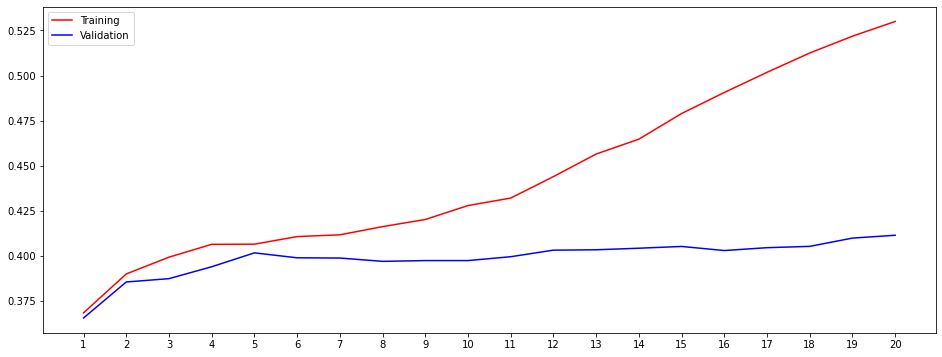

In [135]:
fig, ax = plt.subplots(figsize = (16, 6))
ax.plot(depths, depth_mean_accuracy_scores_train, color = "red", label = "Training")
ax.plot(depths, depth_mean_accuracy_scores_valid, color = "blue", label = "Validation")
ax.set_xticks(depths)
ax.legend()
plt.show()

In [136]:
difference_train_valid = [v - t for v,t in zip(depth_mean_accuracy_scores_train, depth_mean_accuracy_scores_valid)]

In [137]:
decision_tree_mean_accuracy_scores = pd.DataFrame([depth_mean_accuracy_scores_train, depth_mean_accuracy_scores_valid,
                                          difference_train_valid], index = ['Training', 'Validation', 'Difference'], 
                                         columns = depths).T

In [139]:
# decision_tree_mean_accuracy_scores

Problem of overfitting is quite obvious. Depth of 5 the accuracy on both the training and validation set are almost identical. Hence, model with a depth of 5 is fitted.

In [140]:
decision_tree_final = DecisionTreeClassifier(max_depth = 5, random_state = 42).fit(feat_train, labels_train)

Make predictions:

In [144]:
decision_tree_predictions = decision_tree_final.predict(feat_valid)

Check **confusion matrix** to evaluate model performance.

The confusion matrix, also known as error matrix, is a specific table that allows visualization of the performance of an algorithm. Each row of the matrix represents the instances in an actual class while each column represents the instances in a predicted class, or vice versa. The diagonal of the matrix therefore represents all instances that are correctly predicted.

In [145]:
decision_tree_confusion_matrix = confusion_matrix(labels_valid, decision_tree_predictions)

In [146]:
decision_tree_confusion_matrix_plot = ConfusionMatrixDisplay(decision_tree_confusion_matrix,
                                                             display_labels = np.array(["draw", "home", "away"]))

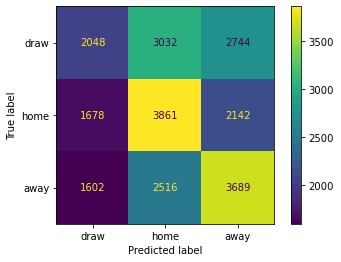

In [148]:
decision_tree_confusion_matrix_plot.plot()

The **classification report** shows the main classification performance metrics:

In [167]:
print(classification_report(labels_valid, decision_tree_predictions))

              precision    recall  f1-score   support

           0       0.38      0.26      0.31      7824
           1       0.41      0.50      0.45      7681
           2       0.43      0.47      0.45      7807

    accuracy                           0.41     23312
   macro avg       0.41      0.41      0.40     23312
weighted avg       0.41      0.41      0.40     23312



As already indicated by the plot comparing accuracy score on training and validation set, the accuracy is around 41 percent. Not bad, not good. Moreover, feature importance is examined to see whether features could be excluded to reduce complexity.

In [150]:
feature_importance = pd.Series(decision_tree_final.feature_importances_,
                               index = features.columns).sort_values(ascending = False)

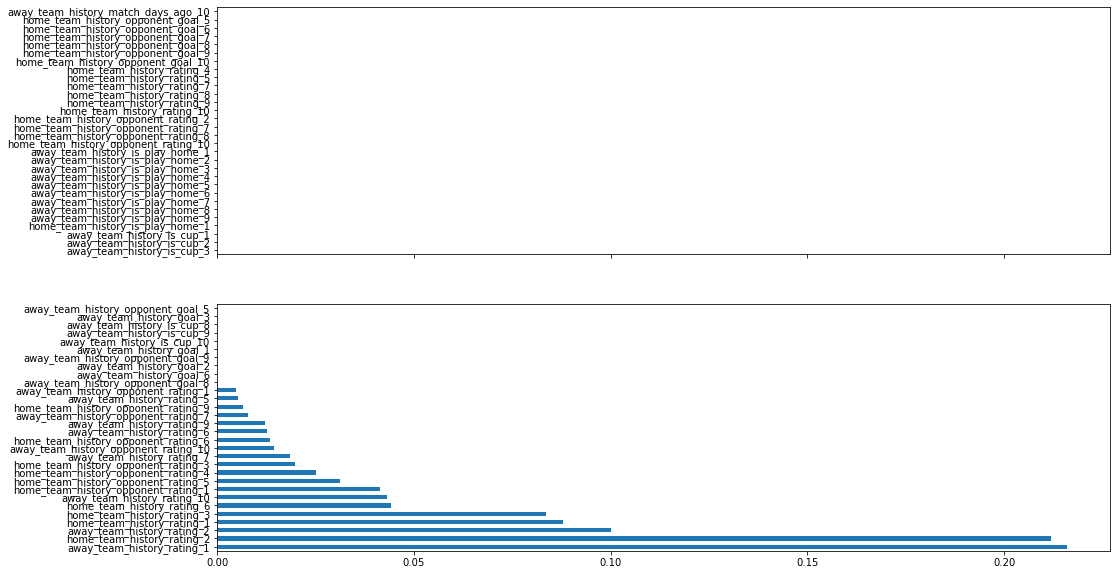

In [151]:
fig, axes = plt.subplots(2, 1, figsize = (16, 10), sharex = True)
feature_importance.tail(30).plot(kind = "barh", ax = axes[0])
feature_importance.head(30).plot(kind = "barh", ax = axes[1])
plt.show()

The charts indicate that only a fraction of all features are important in classifying the targets.

In [157]:
important_features = list(feature_importance[feature_importance > 0.0].index)

In [164]:
features_sparse_scaled = scaler.fit_transform(features_after_resampling[important_features])
features_test_sparse_scaled = scaler.transform(test_data[important_features])
feat_sparse_train, feat_sparse_valid, labels_sparse_train, labels_sparse_valid = train_test_split(features_sparse_scaled,
                                                                                                  labels_after_resampling,
                                                                                                  test_size = 0.2,
                                                                                                  shuffle = True)

In [165]:
decision_tree_sparse = DecisionTreeClassifier(max_depth = 5, random_state = 42).fit(feat_sparse_train, labels_sparse_train)

In [166]:
decision_tree_sparse_predictions = decision_tree_sparse.predict(feat_sparse_valid)

In [168]:
print(classification_report(labels_valid, decision_tree_sparse_predictions))

              precision    recall  f1-score   support

           0       0.34      0.27      0.30      7824
           1       0.33      0.38      0.35      7681
           2       0.33      0.35      0.34      7807

    accuracy                           0.33     23312
   macro avg       0.34      0.34      0.33     23312
weighted avg       0.34      0.33      0.33     23312



Worse results. Up to the next model.

#### Random Forest Classifier

As with the single Decision Tree Classifier, we start with a Random Forest Classifier without parameter tuning.

In [182]:
random_forest_baseline = RandomForestClassifier(random_state = 42, n_jobs = -1)

In [170]:
random_forest_baseline_accuracy_train = evaluate_model(random_forest_baseline).mean()

In [171]:
random_forest_baseline_accuracy_valid = evaluate_model(random_forest_baseline, feat_valid, labels_valid).mean()

In [172]:
print(f'Training set: {round(random_forest_baseline_accuracy_train * 100, 2)} \
vs. Validation set: {round(random_forest_baseline_accuracy_valid * 100, 2)}')

Training set: 63.01 vs. Validation set: 47.74


Similar to the Decision Tree results, we observe overfitting for the baseline Random Forest. Hence, parameter tuning is applied to test several Random Forest Classifier. The tuning can be done with GridSearch:

In [175]:
random_forest_params = {'n_estimators': [100, 500], 'max_depth': [5, 20]}

In [174]:
# with more computational power and a lot of time:
# random_forest_params = {'n_estimators': [100, 500, 1000], 'max_depth': [5, 10, 20], 'max_features': [None, "sqrt", "log2"]}

In [176]:
random_forest_grids = GridSearchCV(random_forest_baseline, param_grid = random_forest_params,
                                   cv = stratified_cross_valid_folds, scoring = "accuracy", n_jobs = -1)

In [177]:
random_forest_grids_fitted = random_forest_grids.fit(feat_train, labels_train)

In [178]:
random_forest_grids_results = pd.DataFrame(random_forest_grids_fitted.cv_results_)

In [179]:
random_forest_grids_mean_results = np.array(random_forest_grids_results.mean_test_score).reshape(2, 2).T

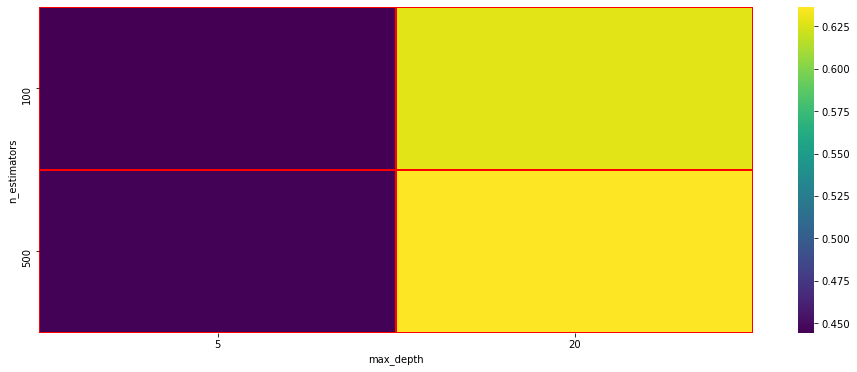

In [180]:
fig, ax = plt.subplots(figsize = (16, 6))
sns.heatmap(random_forest_grids_mean_results, xticklabels = random_forest_params["max_depth"],
            yticklabels = random_forest_params["n_estimators"],
            linecolor = "red", linewidths = 1, cmap = "viridis", ax = ax)
ax.set_xlabel("max_depth")
ax.set_ylabel("n_estimators")
plt.show()

In [181]:
random_forest_grids_mean_results

array([[0.44420727, 0.62805236],
       [0.44511883, 0.63663173]])

As expected, the Random Forest's performance is better conpared to the single Decision Tree. However, an accuracy around 45 percent is still not fascinating.

Due to time restrictions, we continue with a depth of 5 and 100 estimators. Assumption: higher depth increases overfitting (as seen for single Decision Tree) and larger number of estimators results do not yield any improvements (as indicated by the heatmap).

In [184]:
random_forest_final = RandomForestClassifier(n_estimators = 100, max_depth = 5,
                                             random_state = 42, n_jobs = -1).fit(feat_train, labels_train)

In [185]:
random_forest_predictions = random_forest_final.predict(feat_valid)

In [186]:
random_forest_confusion_matrix = confusion_matrix(labels_valid, random_forest_predictions)

In [187]:
random_forest_confusion_matrix_plot = ConfusionMatrixDisplay(random_forest_confusion_matrix,
                                                        display_labels = np.array(["draw", "home", "away"]))

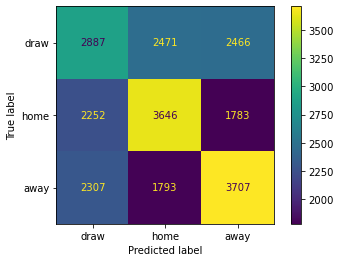

In [188]:
random_forest_confusion_matrix_plot.plot()

In [189]:
print(classification_report(labels_valid, random_forest_predictions, zero_division = 0))

              precision    recall  f1-score   support

           0       0.39      0.37      0.38      7824
           1       0.46      0.47      0.47      7681
           2       0.47      0.47      0.47      7807

    accuracy                           0.44     23312
   macro avg       0.44      0.44      0.44     23312
weighted avg       0.44      0.44      0.44     23312



#### XGB Classifier

Next, a eXtreme Gradient Boosting Classifier is applied on the data.

* **Gradient boosting** involves creating and adding new Decision Trees to the model sequentially. The new trees are created to correct the residual errors in the predictions from the previous trees.
* The drawback to that model is that it tends to **overfit**.
* To accomodate for that drawback, a weighting factor can be applied for the corrections by new trees. This weighting is called the **shrinkage factor** or **learning rate**. Common values for the learning rate range between **0.1 and 0.3**. But values less than 0.1 are feasible as well.
* Lastly, **extreme** indicates the high computational speed.

As for the Random Forest, we use 100 estimators and a depth of 5. Moreover, the following parameters (besides random_state & n_jobs are set:

* learning_rate: see above.
* objective (learning objective): **multi:softmax**, recommended for multiclass classification.
* eval_metric (evaluation metric): **merror**, multiclass classification error rate.
* use_label_encoder: deprecated, recommended value is 'False'.

Sources:
* https://xgboost.readthedocs.io/en/stable/parameter.html#general-parameters
* https://machinelearningmastery.com/tune-learning-rate-for-gradient-boosting-with-xgboost-in-python/

In [122]:
xgb_classifier = xgb.XGBClassifier(n_estimators = 100, max_depth = 5, learning_rate = 0.1, objective = "multi:softmax",
                                   eval_metric = "merror", random_state = 42, n_jobs = -1,
                                   use_label_encoder = False).fit(feat_train, labels_train)

In [193]:
xgb_classifier_accuracy_train = evaluate_model(xgb_classifier).mean()

In [ ]:
xgb_classifier_accuracy_valid = evaluate_model(xgb_classifier, feat_valid, labels_valid).mean()

In [ ]:
print(f'Training set: {round(xgb_classifier_accuracy_train * 100, 2)} \
vs. Validation set: {round(xgb_classifier_accuracy_valid * 100, 2)}')

As expected quite similar results for training and validation set. Next, make predictions:

In [194]:
xgb_classifier_predictions = xgb_classifier.predict(feat_valid)

In [195]:
xgb_classifier_confusion_matrix = confusion_matrix(labels_valid, xgb_classifier_predictions)

In [196]:
xgb_classifier_confusion_matrix_plot = ConfusionMatrixDisplay(xgb_classifier_confusion_matrix,
                                                        display_labels = np.array(["draw", "home", "away"]))

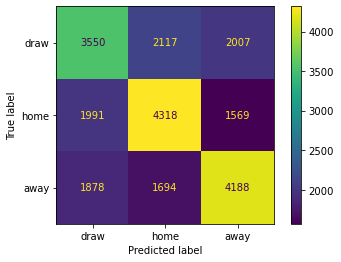

In [197]:
xgb_classifier_confusion_matrix_plot.plot()

In [308]:
print(classification_report(labels_valid, xgb_classifier_predictions))

              precision    recall  f1-score   support

           0       0.48      0.46      0.47      7674
           1       0.53      0.55      0.54      7878
           2       0.54      0.54      0.54      7760

    accuracy                           0.52     23312
   macro avg       0.52      0.52      0.52     23312
weighted avg       0.52      0.52      0.52     23312



Eventually, we use the XGB Classifier to make predictions using the test set:

In [304]:
xgb_classifier_predictions_test = xgb_classifier.predict_proba(features_test_scaled)

In [305]:
submission_xgb_classifier = pd.DataFrame(xgb_classifier_predictions_test, columns = ["draw", "home", "away"])

In [307]:
submission_xgb_classifier = pd.concat([pd.Series(test_data.index, name = 'id'), submission_xgb_classifier], axis = 1)

In [203]:
# xgb_classifier.to_csv("submission_xgb.csv", index = False)

#### Extension: Neural Network

In the next cells, a simple **neural network** is constructed to check whether it could be the XGB classifier.

Set seed for reproducibility:

In [210]:
tensorflow.random.set_seed(69)

Encode the labels:

In [211]:
labels_train_deep_learning = to_categorical(labels_train, num_classes = 3)
labels_valid_deep_learning = to_categorical(labels_valid, num_classes = 3)

Following, a function is define to create the neural network:

In [212]:
def design_neural_network(inputs_df, labels_df):
    # Enable stacking of layers and specify name of neural network:
    network = Sequential(name = 'deep_classifier')
    
    # Input Layer:
    network.add(InputLayer(input_shape = (inputs_df.shape[1], )))
    
    # Hidden Layers. Dropout layers randomly set input units to 0 with a frequency of 0.2 (prevent overfitting).
    network.add(Dense(1024, activation = "relu"))
    network.add(Dropout(0.2))
    network.add(Dense(1024, activation = "relu"))
    network.add(Dropout(0.2))
    network.add(Dense(1024, activation = "relu"))
    
    # Output Layer:
    network.add(Dense(labels_df.shape[1], activation = "softmax"))
    
    # Loss function: crossentropy loss as there are more than two target classes
    loss_func = tensorflow.keras.losses.CategoricalCrossentropy()
    
    # Optimizer: Adam algorithm (stochastic gradient descent method)
    optimizer = Adam(learning_rate = 0.001)
    
    # Metrics:
    accuracy = tensorflow.keras.metrics.CategoricalAccuracy(name = "Accuracy")
    
    # Compiling
    network.compile(loss = loss_func,  optimizer = optimizer, metrics = [accuracy])
    
    return network

Add callback to stop training when metric has stopped to improve:

In [213]:
earlystop = EarlyStopping(min_delta = 0.001, patience = 20, restore_best_weights = True)

Instantiate neural network:

In [214]:
deep_classifier = design_neural_network(feat_train, labels_train_deep_learning)

Fit model to the data. We will work with 10 epochs to avoid long computation time.

In [215]:
epochs_network = 10

In [216]:
deep_classifier_history = deep_classifier.fit(feat_train, labels_train_deep_learning, batch_size = 100,
                                             epochs = epochs_network, callbacks = earlystop,
                                             validation_data = (feat_valid, labels_valid_deep_learning),
                                             verbose = 0)

Visualize the results:

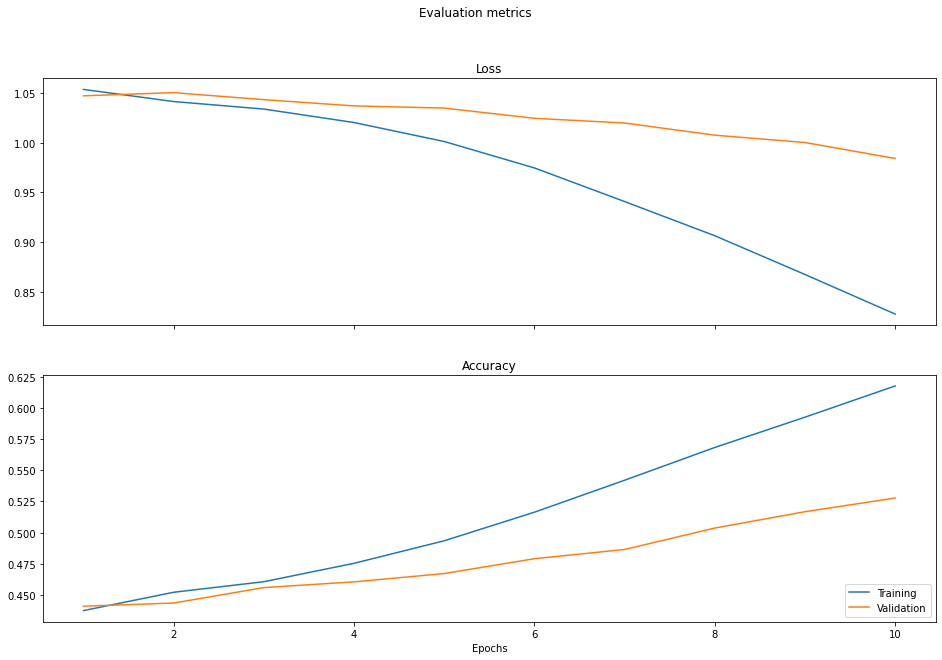

In [217]:
fig, axes = plt.subplots(2, 1, figsize = (16, 10), sharex = True)
axes[0].plot(np.arange(1, len(deep_classifier_history.epoch) + 1), deep_classifier_history.history['loss'],
             label = 'Training Loss')
axes[0].plot(np.arange(1, len(deep_classifier_history.epoch) + 1), deep_classifier_history.history['val_loss'],
             label = 'Validation Loss')
axes[0].set_title("Loss")

axes[1].plot(np.arange(1, len(deep_classifier_history.epoch) + 1), deep_classifier_history.history['Accuracy'],
             label = 'Training Accuracy')
axes[1].plot(np.arange(1, len(deep_classifier_history.epoch) + 1), deep_classifier_history.history['val_Accuracy'],
             label = 'Validation Accuracy')
axes[1].set_title('Accuracy')

axes[1].legend(['Training', 'Validation'], loc = 'lower right')
plt.suptitle('Evaluation metrics')
plt.xlabel('Epochs')

plt.show()

Strong overfitting. However, we will continue with predictions:

In [260]:
deep_classifier_predictions_probabilities = deep_classifier.predict(feat_valid)

In [261]:
deep_classifier_predictions = np.argmax(deep_classifier_predictions_probabilities, axis = 1)

Evaluation:

In [262]:
deep_classifier_confusion_matrix = confusion_matrix(labels_valid, deep_classifier_predictions)

In [263]:
deep_classifier_confusion_matrix_plot = ConfusionMatrixDisplay(deep_classifier_confusion_matrix,
                                                        display_labels = np.array(["draw", "home", "away"]))

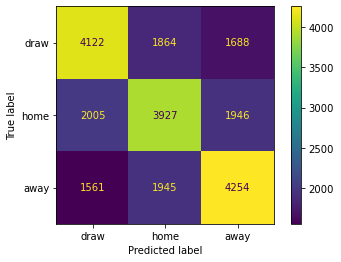

In [264]:
deep_classifier_confusion_matrix_plot.plot()

In [265]:
print(classification_report(labels_valid, deep_classifier_predictions))

              precision    recall  f1-score   support

           0       0.54      0.54      0.54      7674
           1       0.51      0.50      0.50      7878
           2       0.54      0.55      0.54      7760

    accuracy                           0.53     23312
   macro avg       0.53      0.53      0.53     23312
weighted avg       0.53      0.53      0.53     23312



Accuracy above 50 percent, and hence not really better than the XGB classifier. However, lets make predictions on the test data and save the results:

In [290]:
deep_classifier_predictions_test = deep_classifier.predict(features_test_scaled)

In [297]:
submission_deep_classifier = pd.DataFrame(deep_classifier_predictions_test, columns = ["draw", "home", "away"])

In [298]:
submission_deep_classifier = pd.concat([pd.Series(test_data.index, name = 'id'), submission_deep_classifier], axis = 1)

Problem with missing values. Replace with all zeros until better solution:

In [299]:
submission_deep_classifier.isna().sum()

id          0
draw    10132
home    10132
away    10132
dtype: int64

In [300]:
submission_deep_classifier.fillna(value = 0, inplace = True)

In [302]:
submission_deep_classifier.to_csv("submission_nn.csv", index = False)